In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_dir = 'D:/carbon credit/manuscript/nature communications/revision/all data/synthetic data collections/'
plot_dir = 'D:/carbon credit/plot/county_map/2024/'

data_raw = pd.read_excel(data_dir + 'synthesis meta clean_2405_methodCorrected.xlsx')

def generate_study_id(row):
    return hash(row['DOI'])

data_raw['study_id'] = data_raw.apply(generate_study_id, axis =1)

# generate unique ID based on DOI and [DOI, Site_location, Latitude]
def generate_study_site_id(row):
    return hash((row['DOI'], row['Longitude'], row['Latitude']))
# Create a new column 'id' based on the combination of 'study' and 'site'
data_raw['site_id'] = data_raw.apply(generate_study_site_id, axis=1)

# Create a mapping of unique combinations of 'study' and 'site' to ordered sequence starting from 1
id_sequence = {}
sequence_number = 1
for id_ in data_raw['study_id'].unique():
    id_sequence[id_] = sequence_number
    sequence_number += 1
# Map the generated IDs to ordered sequence
data_raw['Study_ID'] = data_raw['study_id'].map(id_sequence)

id_sequence = {}
sequence_number = 1
for id_ in data_raw['site_id'].unique():
    id_sequence[id_] = sequence_number
    sequence_number += 1

# Map the generated IDs to ordered sequence
data_raw['Site_ID'] = data_raw['site_id'].map(id_sequence)

data_raw = data_raw.drop(columns=['study_id', 'site_id'])

In [11]:
# get unique site information for generating soil and weather inputs
unique_sites = data_raw.groupby(data_raw['Site_ID']).first()\
       [['Study_ID', 'State', 'Latitude', 'Longitude', 'Start year', 'End year', 'Experiment start year']].reset_index()
# unique_sites[['Latitude', 'Longitude']] = data_excel.groupby(data_raw['Site_ID']).first()[['Latitude', 'Longitude']].reset_index(drop=True)
unique_sites['Start year'] = unique_sites['Experiment start year'].fillna(unique_sites['Start year'])
unique_sites.loc[unique_sites['Start year'] < 1979, 'Start year'] = 1979
unique_sites['Start year'] = unique_sites['Start year'].fillna(1990)
unique_sites['End year'] = unique_sites['End year'].fillna(2020)
unique_sites = unique_sites.dropna(subset=['Latitude', 'Longitude'])
# unique_sites.to_csv(data_dir + 'unique_siteinfo1.csv', index = False)

In [4]:
# calculate SOC stock
# there is one study that soil depth was described as "whole soil", which was replaced as 150 cm
data_raw['Depth_trt_init'] = data_raw['Depth_trt_init'].replace('whole soil', 100)
data_raw['Depth_ctr_init'] = data_raw['Depth_ctr_init'].replace('whole soil', 100)
data_raw['Depth_trt_end'] = data_raw['Depth_trt_end'].replace('whole soil', 100)
data_raw['Depth_ctr_end'] = data_raw['Depth_ctr_end'].replace('whole soil', 100)

# depth ranges for layered SOC observations were e.g. 0-5, 5-10 (cm), a single number used for whole profile SOC, e.g. 50.
depth_trt_init = data_raw['Depth_trt_init'].astype(str).str.split('-')
depth_trt_init_up = depth_trt_init.str[0].astype(float).fillna(0)
depth_trt_init_up[data_raw['Depth_trt_init'].astype(str).str.split('-').str.len() == 1] = 0
depth_trt_init_lw = depth_trt_init.str[-1].astype(float)

depth_ctr_init = data_raw['Depth_ctr_init'].astype(str).str.split('-')
depth_ctr_init_up = depth_ctr_init.str[0].astype(float).fillna(0)
depth_ctr_init_up[data_raw['Depth_ctr_init'].astype(str).str.split('-').str.len() == 1] = 0
depth_ctr_init_lw = depth_ctr_init.str[-1].astype(float)

depth_trt_end = data_raw['Depth_trt_end'].astype(str).str.split('-')
depth_trt_end_up = depth_trt_end.str[0].astype(float).fillna(0)
depth_trt_end_up[data_raw['Depth_trt_end'].astype(str).str.split('-').str.len() == 1] = 0
depth_trt_end_lw = depth_trt_end.str[-1].astype(float)

depth_ctr_end = data_raw['Depth_ctr_end'].astype(str).str.split('-')
depth_ctr_end_up = depth_ctr_end.str[0].astype(float).fillna(0)
depth_ctr_end_up[data_raw['Depth_ctr_end'].astype(str).str.split('-').str.len() == 1] = 0
depth_ctr_end_lw = depth_ctr_end.str[-1].astype(float)

# SOC stock (t/ha) = concentration (g/kg) * bulk density (g/cm3) * depth (cm) / 10
# print(data_raw['Concentration_ctr_end'].dtypes, data_raw['BD_ctr_end'].dtypes)
SOC_trt_int = data_raw['Concentration_trt_init'] * data_raw['BD_trt_init'] * (depth_trt_init_lw - depth_trt_init_up) / 10
SOC_ctr_int = data_raw['Concentration_ctr_init'] * data_raw['BD_ctr_init'] * (depth_ctr_init_lw - depth_ctr_init_up) / 10
SOC_trt_end = data_raw['Concentration_trt_end'] * data_raw['BD_trt_end'] * (depth_trt_end_lw - depth_trt_end_up) / 10
SOC_ctr_end = data_raw['Concentration_ctr_end'] * data_raw['BD_ctr_end'] * (depth_ctr_end_lw - depth_ctr_end_up) / 10

SOC_trt_int_se = data_raw['Concentration_trt_init_SE'] * data_raw['BD_trt_init'] * (depth_trt_init_lw - depth_trt_init_up) / 10
SOC_ctr_int_se = data_raw['Concentration_ctr_init_SE'] * data_raw['BD_ctr_init'] * (depth_ctr_init_lw - depth_ctr_init_up) / 10
SOC_trt_end_se = data_raw['Concentration_trt_end_SE'] * data_raw['BD_trt_end'] * (depth_trt_end_lw - depth_trt_end_up) / 10
SOC_ctr_end_se = data_raw['Concentration_ctr_end_SE'] * data_raw['BD_ctr_end'] * (depth_ctr_end_lw - depth_ctr_end_up) / 10
# fill up the columns with calcuated values
data_raw['Stock_trt_init'] = data_raw['Stock_trt_init'].fillna(SOC_trt_int)
data_raw['Stock_ctr_init'] = data_raw['Stock_ctr_init'].fillna(SOC_ctr_int)
data_raw['Stock_trt_end'] = data_raw['Stock_trt_end'].fillna(SOC_trt_end)
data_raw['Stock_ctr_end'] = data_raw['Stock_ctr_end'].fillna(SOC_ctr_end)

data_raw['Stock_trt_init_SE'] = data_raw['Stock_trt_init_SE'].fillna(SOC_trt_int_se)
data_raw['Stock_ctr_init_SE'] = data_raw['Stock_ctr_init_SE'].fillna(SOC_ctr_int_se)
data_raw['Stock_trt_end_SE'] = data_raw['Stock_trt_end_SE'].fillna(SOC_trt_end_se)
data_raw['Stock_ctr_end_SE'] = data_raw['Stock_ctr_end_SE'].fillna(SOC_ctr_end_se)

# calculate SOC stock changes (t/ha/year), and delta SOC
data_raw['Experiment start year'] = data_raw['Experiment start year'].fillna(data_raw['Start year'])
data_raw['No_year_SOC'] = data_raw['End year'] - data_raw['Experiment start year']
data_raw['No_year'] = data_raw['End year'] - data_raw['Experiment start year'] + 1

SOC_change_trt = (data_raw['Stock_trt_end'] - data_raw['Stock_trt_init']) / data_raw['No_year_SOC']
SOC_change_ctr = (data_raw['Stock_ctr_end'] - data_raw['Stock_ctr_init']) / data_raw['No_year_SOC']
SOC_change_trt_se = (data_raw['Stock_trt_end_SE']**2 + data_raw['Stock_trt_init_SE']**2) ** 0.5
SOC_change_ctr_se = (data_raw['Stock_ctr_end_SE']**2 + data_raw['Stock_ctr_init_SE']**2) ** 0.5
data_raw['SOC_change_trt_peryr'] = data_raw['SOC_change_trt_peryr'].fillna(SOC_change_trt)
data_raw['SOC_change_ctr_peryr'] = data_raw['SOC_change_ctr_peryr'].fillna(SOC_change_ctr)
data_raw['delta_SOC'] = data_raw['delta_SOC'].fillna(data_raw['SOC_change_trt_peryr'] - data_raw['SOC_change_ctr_peryr'])

# adjust yield moisture to corn 15.5% and soybean 13%
data_raw['Yield_corn_trt'] = data_raw['Yield_corn_trt'] * (1-data_raw['Moisture_corn'].fillna(15.5)/100) / 0.845
data_raw['Yield_corn_ctr'] = data_raw['Yield_corn_ctr'] * (1-data_raw['Moisture_corn'].fillna(15.5)/100) / 0.845
data_raw['Yield_soy_trt'] = data_raw['Yield_soy_trt'] * (1-data_raw['Moisture_soy'].fillna(13)/100) / 0.87
data_raw['Yield_soy_ctr'] = data_raw['Yield_soy_ctr'] * (1-data_raw['Moisture_soy'].fillna(13)/100) / 0.87
# calculate delta yield, N2O, and N leaching
data_raw['delta_yield_corn'] = data_raw['delta_yield_corn'].fillna(data_raw['Yield_corn_trt'] - data_raw['Yield_corn_ctr'])
data_raw['delta_yield_soy'] = data_raw['delta_yield_soy'].fillna(data_raw['Yield_soy_trt'] - data_raw['Yield_soy_ctr'])
data_raw['delta_N2O_corn'] = data_raw['delta_N2O_corn'].fillna(data_raw['N2O_corn_trt'] - data_raw['N2O_corn_ctr'])
data_raw['delta_N2O_soy'] = data_raw['delta_N2O_soy'].fillna(data_raw['N2O_soy_trt'] - data_raw['N2O_soy_ctr'])
data_raw['delta_Nleach_corn'] = data_raw['delta_Nleach_corn'].fillna(data_raw['Nleach_corn_trt'] - data_raw['Nleach_corn_ctr'])
data_raw['delta_Nleach_soy'] = data_raw['delta_Nleach_soy'].fillna(data_raw['Nleach_soy_trt'] - data_raw['Nleach_soy_ctr'])


# assume that inital SOC are the same for control and treatment, then delta SOC = trt_end - ctr_end
delta_SOC_sameinit = (data_raw['Stock_trt_end'] - data_raw['Stock_ctr_end']) / data_raw['No_year_SOC']
data_raw['delta_SOC_sameinit'] = data_raw['delta_SOC'].fillna(delta_SOC_sameinit)


pair_obs, pair_delta_obs = 0, 0
for var in ['Stock_trt_end', 'delta_SOC', 'delta_SOC_sameinit', 'delta_yield_corn', 'delta_yield_soy', \
            'delta_N2O_corn', 'delta_N2O_soy', 'delta_Nleach_corn', 'delta_Nleach_soy']:
    if var not in ['Stock_trt_end', 'delta_SOC']:
        pair_delta_obs += data_raw[var].dropna().shape[0]
    if var not in ['delta_SOC', 'delta_SOC_sameinit']:
        pair_obs += data_raw[var].dropna().shape[0]
    print('Number of paired ' + var, data_raw[var].dropna().shape[0])
print('Total number of paired SOC CC observations',(data_raw['delta_SOC_sameinit'][data_raw['Experiment'] == 'Cover crops']).dropna().shape)
print('Total number of paired SOC NT observations',(data_raw['delta_SOC_sameinit'][data_raw['Experiment'] == 'Tillage']).dropna().shape)
print('Total number of paired observations', pair_obs)
print('Total number of paired effect sizes', pair_delta_obs) # excluded paired SOC observations where time period is unavailable

Number of paired Stock_trt_end 476
Number of paired delta_SOC 134
Number of paired delta_SOC_sameinit 444
Number of paired delta_yield_corn 675
Number of paired delta_yield_soy 234
Number of paired delta_N2O_corn 106
Number of paired delta_N2O_soy 42
Number of paired delta_Nleach_corn 93
Number of paired delta_Nleach_soy 52
Total number of paired SOC CC observations (52,)
Total number of paired SOC NT observations (392,)
Total number of paired observations 1678
Total number of paired effect sizes 1646


In [5]:
# calculate SE of effect sizes (deltaSOC, deltaN2O, deltaYield, deltaNleach)
# reference: https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/effects.html

SOC_change_trt_sd = SOC_change_trt_se * data_raw['No of replicates'] ** 0.5
SOC_change_ctr_sd = SOC_change_ctr_se * data_raw['No of replicates'] ** 0.5
SOC_change_pooled_sd = ((SOC_change_trt_sd ** 2 + SOC_change_ctr_sd ** 2) / 2) ** 0.5
delta_SOC_se = SOC_change_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
data_raw['delta_SOC_SE'] = data_raw['delta_SOC_SE'].fillna(delta_SOC_se)

yield_corn_trt_sd = data_raw['Yield_corn_trt_SE'] * data_raw['No of replicates'] ** 0.5
yield_corn_ctr_sd = data_raw['Yield_corn_ctr_SE'] * data_raw['No of replicates'] ** 0.5
yield_soy_trt_sd = data_raw['Yield_soy_trt_SE'] * data_raw['No of replicates'] ** 0.5
yield_soy_ctr_sd = data_raw['Yield_soy_ctr_SE'] * data_raw['No of replicates'] ** 0.5
yield_corn_pooled_sd = ((yield_corn_trt_sd ** 2 + yield_corn_ctr_sd ** 2) / 2) ** 0.5
yield_soy_pooled_sd = ((yield_corn_trt_sd ** 2 + yield_corn_ctr_sd ** 2) / 2) ** 0.5
delta_yield_corn_se = yield_corn_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
delta_yield_soy_se = yield_soy_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
data_raw['delta_yield_corn_SE'] = data_raw['delta_yield_corn_SE'].fillna(delta_yield_corn_se)
data_raw['delta_yield_soy_SE'] = data_raw['delta_yield_soy_SE'].fillna(delta_yield_soy_se)

N2O_corn_trt_sd = data_raw['N2O_corn_trt_SE'] * data_raw['No of replicates'] ** 0.5
N2O_corn_ctr_sd = data_raw['N2O_corn_ctr_SE'] * data_raw['No of replicates'] ** 0.5
N2O_soy_trt_sd = data_raw['N2O_soy_trt_SE'] * data_raw['No of replicates'] ** 0.5
N2O_soy_ctr_sd = data_raw['N2O_soy_ctr_SE'] * data_raw['No of replicates'] ** 0.5
N2O_corn_pooled_sd = ((yield_corn_trt_sd ** 2 + yield_corn_ctr_sd ** 2) / 2) ** 0.5
N2O_soy_pooled_sd = ((N2O_soy_trt_sd ** 2 + N2O_soy_ctr_sd ** 2) / 2) ** 0.5
delta_N2O_corn_se = N2O_corn_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
delta_N2O_soy_se = N2O_soy_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
data_raw['delta_N2O_corn_SE'] = data_raw['delta_N2O_corn_SE'].fillna(delta_N2O_corn_se)
data_raw['delta_N2O_soy_SE'] = data_raw['delta_N2O_soy_SE'].fillna(delta_N2O_soy_se)

Nleach_corn_trt_sd = data_raw['Nleach_corn_trt_SE'] * data_raw['No of replicates'] ** 0.5
Nleach_corn_ctr_sd = data_raw['Nleach_corn_ctr_SE'] * data_raw['No of replicates'] ** 0.5
Nleach_soy_trt_sd = data_raw['Nleach_soy_trt_SE'] * data_raw['No of replicates'] ** 0.5
Nleach_soy_ctr_sd = data_raw['Nleach_soy_ctr_SE'] * data_raw['No of replicates'] ** 0.5
Nleach_corn_pooled_sd = ((yield_corn_trt_sd ** 2 + yield_corn_ctr_sd ** 2) / 2) ** 0.5
Nleach_soy_pooled_sd = ((yield_soy_trt_sd ** 2 + yield_soy_ctr_sd ** 2) / 2) ** 0.5
delta_Nleach_corn_se = Nleach_corn_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
delta_Nleach_soy_se = Nleach_soy_pooled_sd * (2/data_raw['No of replicates']) ** 0.5
data_raw['delta_Nleach_corn_SE'] = data_raw['delta_Nleach_corn_SE'].fillna(delta_Nleach_corn_se)
data_raw['delta_Nleach_soy_SE'] = data_raw['delta_Nleach_soy_SE'].fillna(delta_Nleach_soy_se)

In [6]:
# sum up SOC stocks in different soil layers
layeredSOC_data = data_raw[data_raw['Layered SOC'] == 'Yes']
layeredSOC_site = layeredSOC_data['Site_ID'][data_raw['Layered SOC'] == 'Yes'].unique()
data_cum = data_raw.copy(deep=True)
SOC_cum, delta_SOC_cum, depth_cum = [], [], []
for site in layeredSOC_site:
    data_tmp = layeredSOC_data[layeredSOC_data['Site_ID'] == site]
#     print(data_tmp[['Author','Stock_trt_init', 'Stock_ctr_init', 'Stock_trt_end', 'Stock_ctr_end']])
    depth_int_up = depth_trt_init_up[layeredSOC_data[layeredSOC_data['Site_ID'] == site].index]
    depth_int_lw = depth_trt_init_lw[layeredSOC_data[layeredSOC_data['Site_ID'] == site].index]
    depth_end_up = depth_trt_end_up[layeredSOC_data[layeredSOC_data['Site_ID'] == site].index]
    depth_end_lw = depth_trt_end_lw[layeredSOC_data[layeredSOC_data['Site_ID'] == site].index]
    depthstep_end = depth_end_lw.unique()
    depthstep_int = depth_int_lw.unique()
#     if len(depthstep_init) == 1:
#         depthstep_init = np.repeat(depthstep_init, len(depthstep_end))
    # how many cases are contained
    depth_int_no = len(depthstep_int)
    depth_end_no = len(depthstep_end)
    depth_no = max(depth_int_no, depth_end_no)
    # cumulate inital SOC stock by cases at each site
    case_no = data_tmp.shape[0] // depth_no
#     print(site, case_no)
    for i in range(case_no):
        data_case = data_tmp.iloc[i*depth_no : (i+1)*depth_no]
        tmp_idx = data_case.index
        depth_case_int_up = depth_int_up[tmp_idx]
        depth_case_int_lw = depth_int_lw[tmp_idx]
        depth_case_end_up = depth_end_up[tmp_idx]
        depth_case_end_lw = depth_end_lw[tmp_idx]
        if len(depth_case_end_up.unique()) == 1:
            SOC_trt_int_tmp = data_case['Stock_trt_init'].values
            SOC_ctr_int_tmp = data_case['Stock_ctr_init'].values
            SOC_trt_end_tmp = data_case['Stock_trt_end'].values
            SOC_ctr_end_tmp = data_case['Stock_ctr_end'].values
            SOC_trt_change_tmp = data_case['SOC_change_trt_peryr'].values
            SOC_ctr_change_tmp = data_case['SOC_change_ctr_peryr'].values
            delta_SOC_tmp = data_case['delta_SOC'].values
            delta_SOC_samint_tmp = data_case['delta_SOC_sameinit'].values
            BD_trt_int_cum = data_case['BD_trt_init'].values[-1]
            BD_ctr_int_cum = data_case['BD_ctr_init'].values[-1]
            BD_trt_end_cum = data_case['BD_trt_end'].values[-1]
            BD_ctr_end_cum = data_case['BD_ctr_end'].values[-1]
            conc_trt_int_cum = data_case['Stock_trt_init'].values[-1]
            conc_ctr_int_cum = data_case['Stock_ctr_init'].values[-1]
            conc_trt_end_cum = data_case['Stock_trt_end'].values[-1]
            conc_ctr_end_cum = data_case['Stock_ctr_end'].values[-1]

        else:
            SOC_trt_int_tmp = data_case['Stock_trt_init'].cumsum().values
            SOC_ctr_int_tmp = data_case['Stock_ctr_init'].cumsum().values
            SOC_trt_end_tmp = data_case['Stock_trt_end'].cumsum().values
            SOC_ctr_end_tmp = data_case['Stock_ctr_end'].cumsum().values
            SOC_trt_change_tmp = data_case['SOC_change_trt_peryr'].cumsum().values
            SOC_ctr_change_tmp = data_case['SOC_change_ctr_peryr'].cumsum().values
            delta_SOC_tmp = data_case['delta_SOC'].cumsum().values
            delta_SOC_samint_tmp = data_case['delta_SOC_sameinit'].cumsum().values
            # calculated cumulative bulk density and SOC concentration
            BD_trt_int_cum =(data_case['BD_trt_init'] * (depth_case_int_lw - depth_case_int_up)).sum(min_count=1) \
            /(depth_case_end_lw - depth_case_end_up).sum()
            BD_ctr_int_cum =(data_case['BD_ctr_init'] * (depth_case_int_lw - depth_case_int_up)).sum(min_count=1) \
            /(depth_case_end_lw - depth_case_end_up).sum()
            BD_trt_end_cum =(data_case['BD_trt_end'] * (depth_case_end_lw - depth_case_end_up)).sum(min_count=1) \
            /(depth_case_end_lw - depth_case_end_up).sum()
            BD_ctr_end_cum =(data_case['BD_ctr_end'] * (depth_case_end_lw - depth_case_end_up)).sum(min_count=1) \
            /(depth_case_end_lw - depth_case_end_up).sum()
            conc_trt_int_cum = data_case['Stock_trt_init'].sum() / (BD_trt_int_cum * (depth_case_int_lw - depth_case_int_up).sum())
            conc_ctr_int_cum = data_case['Stock_ctr_init'].sum() / (BD_ctr_int_cum * (depth_case_int_lw - depth_case_int_up).sum())
            conc_trt_end_cum = data_case['Stock_trt_end'].sum() / (BD_trt_end_cum * (depth_case_end_lw - depth_case_end_up).sum())
            conc_ctr_end_cum = data_case['Stock_ctr_end'].sum() / (BD_ctr_end_cum * (depth_case_end_lw - depth_case_end_up).sum())

#         print(site, tmp_idx, SOC_trt_int_tmp, SOC_ctr_int_tmp, SOC_trt_end_tmp, SOC_ctr_end_tmp)
        SOC_cum.append(np.stack((SOC_trt_int_tmp, SOC_ctr_int_tmp, SOC_trt_end_tmp, SOC_ctr_end_tmp)))
        delta_SOC_cum.append(np.stack((delta_SOC_tmp, delta_SOC_samint_tmp)))
#         print('depthstep_init', len(depthstep_init), len(depthstep_end))
        depth_cum.append(np.stack((depth_case_int_lw, depth_case_int_lw, depth_case_end_lw, depth_case_end_lw)))
        # add cumulated SOC values into the raw dataset
        data_raw.loc[tmp_idx, 'Depth_trt_init'] = depth_int_lw[tmp_idx].values
        data_raw.loc[tmp_idx, 'Depth_ctr_init'] = depth_int_lw[tmp_idx].values
        data_raw.loc[tmp_idx, 'Depth_trt_end'] = depth_end_lw[tmp_idx].values
        data_raw.loc[tmp_idx, 'Depth_ctr_end'] = depth_end_lw[tmp_idx].values
        
        data_raw.loc[tmp_idx, 'Stock_trt_init'] = SOC_trt_int_tmp
        data_raw.loc[tmp_idx, 'Stock_ctr_init'] = SOC_ctr_int_tmp
        data_raw.loc[tmp_idx, 'Stock_trt_end'] = SOC_trt_end_tmp
        data_raw.loc[tmp_idx, 'Stock_ctr_end'] = SOC_ctr_end_tmp
        data_raw.loc[tmp_idx, 'SOC_change_trt_peryr'] = SOC_trt_change_tmp
        data_raw.loc[tmp_idx, 'SOC_change_ctr_peryr'] = SOC_ctr_change_tmp
        data_raw.loc[tmp_idx, 'delta_SOC'] = delta_SOC_tmp
        data_raw.loc[tmp_idx, 'delta_SOC_sameinit'] = delta_SOC_samint_tmp
        
        data_cum.loc[tmp_idx[-1], 'Depth_trt_init'] = depth_int_lw.values[-1]
        data_cum.loc[tmp_idx[-1], 'Depth_ctr_init'] = depth_int_lw.values[-1]
        data_cum.loc[tmp_idx[-1], 'Depth_trt_end'] = depth_end_lw.values[-1]
        data_cum.loc[tmp_idx[-1], 'Depth_ctr_end'] = depth_end_lw.values[-1]

        data_cum.loc[tmp_idx[-1], 'BD_trt_init'] = BD_trt_int_cum
        data_cum.loc[tmp_idx[-1], 'BD_ctr_init'] = BD_ctr_int_cum
        data_cum.loc[tmp_idx[-1], 'BD_trt_end'] = BD_trt_end_cum
        data_cum.loc[tmp_idx[-1], 'BD_ctr_end'] = BD_ctr_end_cum
        data_cum.loc[tmp_idx[-1], 'Concentration_trt_end'] = conc_trt_int_cum
        data_cum.loc[tmp_idx[-1], 'Concentration_ctr_end'] = conc_ctr_int_cum
        data_cum.loc[tmp_idx[-1], 'Concentration_trt_end'] = conc_trt_end_cum
        data_cum.loc[tmp_idx[-1], 'Concentration_ctr_end'] = conc_ctr_end_cum
        
        data_cum.loc[tmp_idx[-1], 'Stock_trt_init'] = SOC_trt_int_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'Stock_ctr_init'] = SOC_ctr_int_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'Stock_trt_end'] = SOC_trt_end_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'Stock_ctr_end'] = SOC_ctr_end_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'SOC_change_trt_peryr'] = SOC_trt_change_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'SOC_change_ctr_peryr'] = SOC_ctr_change_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'delta_SOC'] = delta_SOC_tmp[-1]
        data_cum.loc[tmp_idx[-1], 'delta_SOC_sameinit'] = delta_SOC_samint_tmp[-1]
        data_cum = data_cum.drop(tmp_idx[:-1])
data_cum = data_cum.reset_index(drop=True)

Text(0, 0.5, 'Cumulative SOC stock (t/ha)')

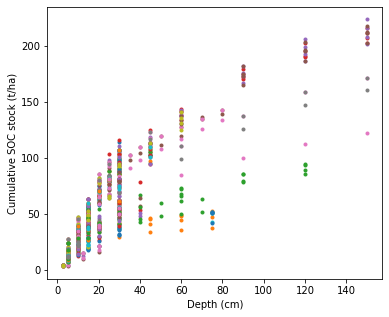

In [7]:
# plot cumulative SOC stock curve from layered SOC observations

fig1, ax1 = plt.subplots(figsize=(6,5))
for i in range(len(SOC_cum)):
    ax1.plot(depth_cum[i].flatten(), SOC_cum[i].flatten(), '.')
ax1.set_xlabel('Depth (cm)')
ax1.set_ylabel('Cumulative SOC stock (t/ha)')

In [12]:
# fit quadratic curve that forces through (0,0) for sites with depth ≥ 100 cm
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf

def qaudraticfit_func(x, a, b):
    # Curve fitting function
    return a * x**2 + b * x

x, y = [], []
for i in range(len(SOC_cum)):

    if np.nanmax(depth_cum[i]) >= 100:
        x.append(depth_cum[i].flatten())
        y.append(SOC_cum[i].flatten())
#         ax1.plot(depth_cum[i].flatten(), SOC_cum[i].flatten(), '.')
x1 = [ele for list1 in x for ele in list1]
y1 = [ele for list1 in y for ele in list1]
xy = np.stack((x1, y1))
xy = xy[:, ~np.any(np.isnan(xy), axis = 0)]

df_qaudratic = pd.DataFrame({'x': xy[0], 'y': xy[1]})

params = curve_fit(qaudraticfit_func, xy[0], xy[1])
weights = np.append(params[0], 0)
quadratic_fit = np.poly1d(weights)
x_fit = np.linspace(0, 150, 75)
y_fit = quadratic_fit(x_fit)
alldata_qaudratic = smf.ols(formula='y ~ quadratic_fit(x)', data=df_qaudratic).fit()
plateau_point = -(weights[1] / 2 / weights[0])
plateau_SOC = quadratic_fit(plateau_point)
weights_percent = weights/plateau_SOC
print('fitted qaudratic curve wights:', weights, 'plateau point', plateau_point)

alldata_qaudratic.summary()

fitted qaudratic curve wights: [-0.00681823  2.27960824  0.        ] plateau point 167.17009386495104


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     332.1
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           5.20e-35
Time:                        21:30:08   Log-Likelihood:                -539.46
No. Observations:                 112   AIC:                             1083.
Df Residuals:                     110   BIC:                             1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.2397      6.835      1.352      0.179      -4.307      22.786
quadratic_fit(x)     0.9368      0.051     18.223      0.000       0.835       1.039
==============================================================================
Omnibus:                       25.534   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.882
Skew:                          -1.270   Prob(JB):                     4.39e-08
Kurtosis:                       3.897   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.3, 0.1, 'y = -0.0036x$^2$+1.20x')

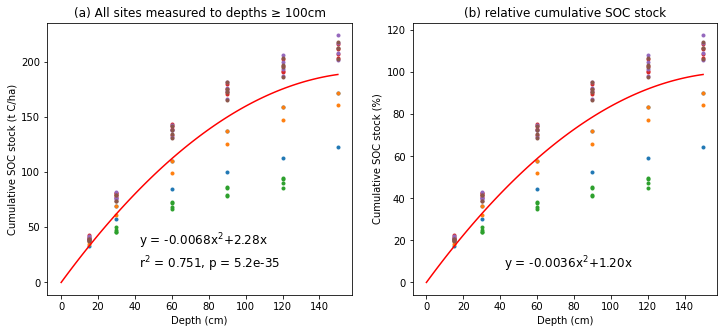

In [13]:
# plot cumulative SOC and the fitted qaudratic curve
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
for i in range(len(x)):
    ax1.plot(x[i], y[i], '.')
    ax2.plot(x[i], y[i] / plateau_SOC * 100, '.')
ax1.plot(x_fit, y_fit, 'red')
ax2.plot(x_fit, y_fit / plateau_SOC * 100, 'red')
ax1.set_xlabel('Depth (cm)')
ax1.set_ylabel('Cumulative SOC stock (t C/ha)')
ax1.set_title('(a) All sites measured to depths ≥ 100cm')
ax1.text(0.3, 0.1, r'y = {:.4f}x$^2$+{:.2f}x' '\n' r'r$^2$ = 0.751, p = 5.2e-35'.format(weights[0],weights[1]), fontsize = 12, \
         transform=ax1.transAxes)
ax2.set_xlabel('Depth (cm)')
ax2.set_ylabel('Cumulative SOC stock (%)')
ax2.set_title('(b) relative cumulative SOC stock')
ax2.text(0.3, 0.1, r'y = {:.4f}x$^2$+{:.2f}x'.format(weights_percent[0] * 100,weights_percent[1] * 100), \
         fontsize = 12, transform=ax2.transAxes)

# fig1.savefig(plot_dir + 'qaudratic_curve_SOC_sites100cm.png', dpi=300)

In [17]:
# fit cumulative SOC stock to a qaudratic curve that forces through (0,0) at one site with depth = 150 cm
case_depth_50 = []
case_n, layer_n = len(SOC_cum), len(SOC_cum[0][0])
for case in range(case_n):
    if depth_cum[case][-1][-1] == 150:
        case_depth_50.append(case)
print(case_n, len(case_depth_50))

SOC_cum_50 = [SOC_cum[i] for i in case_depth_50[2:]]
depth_cum_50 = [depth_cum[i] for i in case_depth_50[2:]]
# print(cumSOC, cumDepth)
# print(SOC_cum_50)

# fit cumulative SOC stock to qaudratic curve
x, y = np.array(depth_cum_50[0]).flatten(), np.array(SOC_cum_50[0]).flatten()
for i in range(1, len(SOC_cum_50)):
    x = np.concatenate((x, np.array(depth_cum_50[i]).flatten()))
    y = np.concatenate((y, np.array(SOC_cum_50[i]).flatten()))
print(x.shape, y.shape)
xy = np.stack((x, y))
xy = xy[:, ~np.any(np.isnan(xy), axis = 0)]
# print(xy)
df_qaudratic = pd.DataFrame({'x': xy[0], 'y': xy[1]})

params = curve_fit(qaudraticfit_func, x, y)
weights = np.append(params[0], 0)
quadratic_fit = np.poly1d(weights)
x_fit = np.linspace(0, 150, 75)
y_fit = quadratic_fit(x_fit)
onesite_qaudratic = smf.ols(formula='y ~ quadratic_fit(x)', data=df_qaudratic).fit()
plateau_point = -(weights[1] / 2 / weights[0])
plateau_SOC = quadratic_fit(plateau_point)
weights_percent = weights/plateau_SOC
print('fitted qaudratic curve wights:', weights, 'plateau point', plateau_point)

onesite_qaudratic.summary()

150 5
(72,) (72,)
fitted qaudratic curve wights: [-0.00945514  2.80629768  0.        ] plateau point 148.40060154179616


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     8955.
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           1.31e-75
Time:                        21:34:21   Log-Likelihood:                -224.88
No. Observations:                  72   AIC:                             453.8
Df Residuals:                      70   BIC:                             458.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0785      1.594      1.304      0.196      -1.100       5.257
quadratic_fit(x)     0.9876      0.010     94.631      0.000       0.967       1.008
==============================================================================
Omnibus:                        1.095   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.507
Skew:                           0.049   Prob(JB):                        0.776
Kurtosis:                       3.399   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[116.67702746 186.07834232 208.20394459]


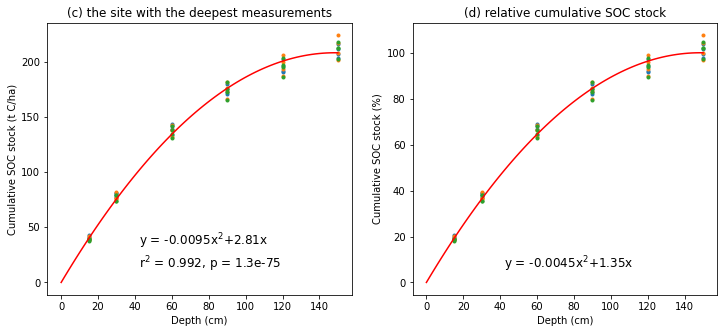

In [18]:
# plot cumulative SOC and the fitted qaudratic curve
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
for i in range(len(SOC_cum_50)):
    ax1.plot(depth_cum_50[i].flatten(), SOC_cum_50[i].flatten(), '.')
    ax2.plot(depth_cum_50[i].flatten(), SOC_cum_50[i].flatten() / plateau_SOC * 100, '.')
ax1.plot(x_fit, y_fit, 'red')
ax2.plot(x_fit, y_fit / plateau_SOC * 100, 'red')
ax1.set_xlabel('Depth (cm)')
ax1.set_ylabel('Cumulative SOC stock (t C/ha)')
ax1.set_title('(c) the site with the deepest measurements')
ax1.text(0.3, 0.1, r'y = {:.4f}x$^2$+{:.2f}x' '\n' r'r$^2$ = 0.992, p = 1.3e-75'.format(weights[0],weights[1]), fontsize = 12, \
         transform=ax1.transAxes)
ax2.set_xlabel('Depth (cm)')
ax2.set_ylabel('Cumulative SOC stock (%)')
ax2.set_title('(d) relative cumulative SOC stock')
ax2.text(0.3, 0.1, r'y = {:.4f}x$^2$+{:.2f}x'.format(weights_percent[0] * 100,weights_percent[1] * 100), \
         fontsize = 12, transform=ax2.transAxes)

fig1.savefig(plot_dir + 'qaudratic_curve_SOC.png', dpi=300)
print(quadratic_fit(np.array([50, 100, 150])))

In [21]:
# incorporate soil and weather inputs
soil_file = pd.read_csv(data_dir + '../soil and weather/metaforest_sites_soil.csv')
weather_file = pd.read_csv(data_dir + '../soil and weather/metaforest_sites_weather_new.csv')
soil_vars = ['pH', 'BD', 'Clay', 'Silt', 'Sand', 'Ks', 'FC', 'SOC', 'CEC']
weather_vars = ['MAP', 'SPP', 'GSP', 'MAT', 'MCGDD', 'CCGDD', 'NSR', 'VPD']

# calculate ratio of observed bulk densities, treatment vs. control
BD_ratio_CC = (data_cum['BD_trt_end'] /  data_cum['BD_ctr_end'])[data_cum['Experiment'] == 'Cover crops'].mean()
BD_ratio_NT = (data_cum['BD_trt_end'] /  data_cum['BD_ctr_end'])[data_cum['Experiment'] == 'Tillage'].mean()
Con_ratio_CC = (data_cum['Concentration_trt_end'] /  data_cum['Concentration_ctr_end'])[data_cum['Experiment'] == 'Cover crops'].mean()
Con_ratio_NT = (data_cum['Concentration_trt_end'] /  data_cum['Concentration_ctr_end'])[data_cum['Experiment'] == 'Tillage'].mean()
data_cum['BD_ratio'] = [0] * data_cum.shape[0]
print(BD_ratio_CC, BD_ratio_NT, Con_ratio_CC, Con_ratio_NT)

for i in range(data_cum.shape[0]):
    site_ID = data_cum['Site_ID'].loc[i]
    lat = round(data_cum['Latitude'].loc[i], 5)
    lon = round(data_cum['Longitude'].loc[i], 5)
    experiment = data_cum['Experiment'].loc[i]
    soil_i = soil_file.loc[(soil_file['Latitude'].round(5) == lat) & (soil_file['Longitude'].round(5) == lon)].index
    weather_i = weather_file.loc[(weather_file['Lat'].round(5) == lat) & (weather_file['Long'].round(5) == lon)].index
    if len(soil_i) > 0:
        data_cum.loc[i, soil_vars] = soil_file.loc[soil_i[0], soil_vars].values
    if len(weather_i) > 0:
        data_cum.loc[i, weather_vars] = weather_file.loc[weather_i[0], weather_vars].values
    if experiment == 'Cover crops':
        data_cum.loc[i, 'BD_ratio'] = BD_ratio_CC
    else:
        data_cum.loc[i, 'BD_ratio'] = BD_ratio_NT
        
## gapfill bulk density, deltaSOC using gSSURGO soil data
stock_trt_end_filled = data_cum['Concentration_trt_end'] * data_cum['BD'] * data_cum['BD_ratio']
stock_ctr_end_filled = data_cum['Concentration_ctr_end'] * data_cum['BD']
delta_SOC_filled = (stock_trt_end_filled - stock_ctr_end_filled) / data_cum['No_year_SOC']
data_cum.loc[:,'Stock_trt_end_filled'] = data_cum['Stock_trt_end'].fillna(stock_trt_end_filled)
data_cum.loc[:,'Stock_ctr_end_filled'] = data_cum['Stock_trt_end'].fillna(stock_ctr_end_filled)
data_cum.loc[:,'delta_SOC_filled'] = data_cum['delta_SOC_sameinit'].fillna(delta_SOC_filled)

0.9877365623659677 1.004140438287985 1.031051389403597 1.263534435470648


In [37]:
import math

# calculate depth-transformed SOC stocks using the fitted quadratic curve: y = -0.000043x^2 + 0.013x
# SOC are transformed into rep. values at depth = 30cm for cover crop data and depth = 60 for no-till.

def depth_transform(stock, depth, refer_depth):
    Cd = weights_percent[0] * depth.astype(float) ** 2 + weights_percent[1] * depth.astype(float)
    refer_Cd = weights_percent[0] * refer_depth ** 2 + weights_percent[1] * refer_depth
    refer_stock = refer_Cd / Cd * stock
    return refer_stock
def NT_effect_transform(delta_SOC, depth, refer_depth):
    Rd = 0.72 * np.exp(-0.12 * depth.astype(float)) + 0.028 # deltaSOC/Stock_ctr, 0.028 + 0.72 exp (-0.12d)
    refer_Rd = 0.72 * math.exp(-0.12 * refer_depth) + 0.028
    refer_delta_SOC = refer_Rd / Rd * delta_SOC
    return refer_delta_SOC
def NT_effect_transform_cumulative(delta_SOC, depth, refer_depth):
    Cd = weights_percent[0] * depth.astype(float) ** 2 + weights_percent[1] * depth.astype(float)
    refer_Cd = weights_percent[0] * refer_depth ** 2 + weights_percent[1] * refer_depth
    Rd = 0.72 * np.exp(-0.12 * depth.astype(float)) + 0.028 # deltaSOC/Stock_ctr, 0.028 + 0.72 exp (-0.12d)
    refer_Rd = 0.72 * math.exp(-0.12 * refer_depth) + 0.028
    refer_delta_SOC = (refer_Rd / Rd) * (refer_Cd / Cd) * delta_SOC
    return refer_delta_SOC

data_cum['No_year_SOC'] = data_cum['No_year_SOC'].replace(0, np.nan)
data_cum['Stock_trt_init_30'] = depth_transform(data_cum['Stock_trt_init'], data_cum['Depth_trt_init'], 30)
data_cum['Stock_ctr_init_30'] = depth_transform(data_cum['Stock_ctr_init'], data_cum['Depth_ctr_init'], 30)
data_cum['Stock_trt_end_30'] = depth_transform(data_cum['Stock_trt_end'], data_cum['Depth_trt_end'], 30)
data_cum['Stock_ctr_end_30'] = depth_transform(data_cum['Stock_ctr_end'], data_cum['Depth_ctr_end'], 30)
data_cum['Stock_trt_end_filled_30'] = depth_transform(data_cum['Stock_trt_end_filled'], data_cum['Depth_trt_end'], 30)
data_cum['Stock_ctr_end_filled_30'] = depth_transform(data_cum['Stock_ctr_end_filled'], data_cum['Depth_ctr_end'], 30)
data_cum['Stock_trt_init_60'] = depth_transform(data_cum['Stock_trt_init'], data_cum['Depth_trt_init'], 60)
data_cum['Stock_ctr_init_60'] = depth_transform(data_cum['Stock_ctr_init'], data_cum['Depth_ctr_init'], 60)
data_cum['Stock_trt_end_60'] = depth_transform(data_cum['Stock_trt_end'], data_cum['Depth_trt_end'], 60)
data_cum['Stock_ctr_end_60'] = depth_transform(data_cum['Stock_ctr_end'], data_cum['Depth_ctr_end'], 60)
data_cum['Stock_trt_end_filled_60'] = depth_transform(data_cum['Stock_trt_end_filled'], data_cum['Depth_trt_end'], 60)
data_cum['Stock_ctr_end_filled_60'] = depth_transform(data_cum['Stock_ctr_end_filled'], data_cum['Depth_ctr_end'], 60)

data_cum['SOC_change_trt_peryr_30'] = (data_cum['Stock_trt_end_30'] - data_cum['Stock_trt_init_30']) / data_cum['No_year_SOC']
data_cum['SOC_change_ctr_peryr_30'] = (data_cum['Stock_ctr_end_30'] - data_cum['Stock_ctr_init_30']) / data_cum['No_year_SOC']
data_cum['delta_SOC_30'] = data_cum['SOC_change_trt_peryr_30'] - data_cum['SOC_change_ctr_peryr_30']
# data_cum['delta_SOC_30'] = data_cum['delta_SOC_30'].fillna(depth_transform(data_cum['delta_SOC'], data_cum['Depth_trt_end'], 30))
data_cum['delta_SOC_sameinit_30'] = data_cum['delta_SOC_30'].fillna(\
                                (data_cum['Stock_trt_end_30'] - data_cum['Stock_ctr_end_30']) / data_cum['No_year_SOC'])
data_cum['delta_SOC_filled_30'] = data_cum['delta_SOC_sameinit_30'].fillna(\
                                (data_cum['Stock_trt_end_filled_30'] - data_cum['Stock_ctr_end_filled_30']) / data_cum['No_year_SOC'])
data_cum['SOC_change_trt_peryr_60'] = (data_cum['Stock_trt_end_60'] - data_cum['Stock_trt_init_60']) / data_cum['No_year_SOC']
data_cum['SOC_change_ctr_peryr_60'] = (data_cum['Stock_ctr_end_60'] - data_cum['Stock_ctr_init_60']) / data_cum['No_year_SOC']
data_cum['delta_SOC_60'] = data_cum['SOC_change_trt_peryr_60'] - data_cum['SOC_change_ctr_peryr_60']
data_cum['delta_SOC_sameinit_60'] = data_cum['delta_SOC_60'].fillna(\
                                (data_cum['Stock_trt_end_60'] - data_cum['Stock_ctr_end_60']) / data_cum['No_year_SOC'])
data_cum['delta_SOC_filled_60'] = data_cum['delta_SOC_sameinit_60'].fillna(\
                                (data_cum['Stock_trt_end_filled_60'] - data_cum['Stock_ctr_end_filled_60']) / data_cum['No_year_SOC'])

# create 3 observations of delta_SOC: non-gapfilled, gapfilled assuming same inital SOC, and gapfilled using SSURGO bulk density
# delta_SOC at 0-60 cm for no-till
data_cum['delta_SOC_NTeffect_60'] = NT_effect_transform(data_cum['delta_SOC'], data_cum['Depth_ctr_end'], 60)
data_cum['delta_SOC_sameinit_NTeffect_60'] = NT_effect_transform(data_cum['delta_SOC_sameinit'], data_cum['Depth_ctr_end'], 60)
data_cum['delta_SOC_filled_NTeffect_60'] = NT_effect_transform(data_cum['delta_SOC_filled'], data_cum['Depth_ctr_end'], 60)

# delta_SOC at 0-30 cm for cover crop
data_cum['delta_SOC_30'] = data_cum['delta_SOC_30'].fillna(depth_transform(data_cum['delta_SOC'], data_cum['Depth_trt_end'], 30))
data_cum['delta_SOC_sameinit_30'] = data_cum['delta_SOC_30'].fillna(\
                                (data_cum['Stock_trt_end_30'] - data_cum['Stock_ctr_end_30']) / data_cum['No_year_SOC'])
data_cum['delta_SOC_filled_30'] = data_cum['delta_SOC_sameinit_30'].fillna(\
                                (data_cum['Stock_trt_end_filled_30'] - data_cum['Stock_ctr_end_filled_30']) / data_cum['No_year_SOC'])

# save the processed dataframes
# data_cum = data_cum.reset_index(drop=True)
# data_raw.to_csv(data_dir + 'model inputs_2405/meta analysis data-layered SOC.csv', index=False)
# data_cum.to_csv(data_dir + 'model inputs_2405/meta analysis data-cumulative SOC.csv', index=False)

In [45]:
# arrange target variables and predictors
# save seperate tables of OSC, N2O, N leaching, yield for model development
site_vars = ['Experiment', 'Study_ID', 'Site_ID', 'State', 'Latitude', 'Longitude']
SOC_vars = ['Depth_ctr_end', 'delta_SOC', 'delta_SOC_sameinit', 'delta_SOC_filled', 
           'delta_SOC_30', 'delta_SOC_sameinit_30', 'delta_SOC_filled_30',
          'delta_SOC_60', 'delta_SOC_sameinit_60', 'delta_SOC_filled_60',
          'delta_SOC_NTeffect_60', 'delta_SOC_sameinit_NTeffect_60', 'delta_SOC_filled_NTeffect_60']
otherObs_vars = ['delta_N2O_corn', 'delta_N2O_soy','delta_yield_corn', 'delta_yield_soy','delta_Nleach_corn', 'delta_Nleach_soy']
manage_vars = ['vi', 'No_year', 'No_year_SOC', 'Rotation', 'Legume or not', 'N rate', 'Irrigation', 'Tillage type']

# Exclude two study for high risk of bias, and mixed reported rotation experiments
data_model = data_cum[~data_cum['Study_ID'].isin([260, 266])]

# calculate approximate sampling variance
data_model['vi'] = 1 / data_model['No of replicates'] ** 0.5
# fill na in legume with None (no CC)
data_model["Legume or not"] = data_model["Legume or not"].fillna('None')

# output tables for meta-analysis model development
SOC_model_inputs = data_model[site_vars + SOC_vars + manage_vars + soil_vars + weather_vars]
SOC_model_inputs = SOC_model_inputs.dropna(subset=['delta_SOC_filled']).reset_index(drop=True)

N2O_model_corn = data_model[site_vars + ['delta_N2O_corn'] + manage_vars + soil_vars + weather_vars]
N2O_model_corn = N2O_model_corn.rename(columns={'delta_N2O_corn': 'delta_N2O'})
N2O_model_corn = N2O_model_corn.dropna(subset=['delta_N2O']).reset_index(drop=True)
N2O_model_corn['Crop'] = ['Corn'] * N2O_model_corn.shape[0]
N2O_model_soy = data_model[site_vars + ['delta_N2O_soy'] + manage_vars + soil_vars + weather_vars]
N2O_model_soy = N2O_model_soy.rename(columns={'delta_N2O_soy': 'delta_N2O'})
N2O_model_soy = N2O_model_soy.dropna(subset=['delta_N2O']).reset_index(drop=True)
N2O_model_soy['Crop'] = ['Soybean'] * N2O_model_soy.shape[0]
N2O_model_inputs = pd.concat((N2O_model_corn, N2O_model_soy), ignore_index = True)

Nleach_model_corn = data_model[site_vars + ['delta_Nleach_corn'] + manage_vars + soil_vars + weather_vars]
Nleach_model_corn = Nleach_model_corn.rename(columns={'delta_Nleach_corn': 'delta_Nleach'})
Nleach_model_corn = Nleach_model_corn.dropna(subset=['delta_Nleach']).reset_index(drop=True)
Nleach_model_corn['Crop'] = ['Corn'] * Nleach_model_corn.shape[0]
Nleach_model_soy = data_model[site_vars + ['delta_Nleach_soy'] + manage_vars + soil_vars + weather_vars]
Nleach_model_soy = Nleach_model_soy.rename(columns={'delta_Nleach_soy': 'delta_Nleach'})
Nleach_model_soy = Nleach_model_soy.dropna(subset=['delta_Nleach']).reset_index(drop=True)
Nleach_model_soy['Crop'] = ['Soybean'] * Nleach_model_soy.shape[0]
Nleach_model_inputs = pd.concat((Nleach_model_corn, Nleach_model_soy), ignore_index = True)

yld_model_corn = data_model[site_vars + ['delta_yield_corn'] + manage_vars + soil_vars + weather_vars]
yld_model_corn = yld_model_corn.rename(columns={'delta_yield_corn': 'delta_yield'})
yld_model_corn = yld_model_corn.dropna(subset=['delta_yield']).reset_index(drop=True)
yld_model_corn['Crop'] = ['Corn'] * yld_model_corn.shape[0]
yld_model_soy = data_model[site_vars + ['delta_yield_soy'] + manage_vars + soil_vars + weather_vars]
yld_model_soy = yld_model_soy.rename(columns={'delta_yield_soy': 'delta_yield'})
yld_model_soy = yld_model_soy.dropna(subset=['delta_yield']).reset_index(drop=True)
yld_model_soy['Crop'] = ['Soybean'] * yld_model_soy.shape[0]
yld_model_inputs = pd.concat((yld_model_corn, yld_model_soy), ignore_index = True)

change_colname = {"Legume or not": "Legume", "Tillage type": "Tillage", 'N rate': 'Nrate', \
                  'SOC': 'gSOC', 'Latitude': 'Lat', 'Longitude': 'Lon', 'Depth_ctr_end': 'Depth'}
SOC_model_inputs = SOC_model_inputs.rename(columns=change_colname)
N2O_model_inputs = N2O_model_inputs.rename(columns=change_colname)
Nleach_model_inputs = Nleach_model_inputs.rename(columns=change_colname)
yld_model_inputs = yld_model_inputs.rename(columns=change_colname)

# cap out 1% extreme data points from yield dataset due to large data quantity
cap1, cap99 = yld_model_inputs['delta_yield'].quantile(0.01), yld_model_inputs['delta_yield'].quantile(0.99)
print(cap1, cap99)
yld_model_inputs = yld_model_inputs[(yld_model_inputs['delta_yield'] > cap1) & (yld_model_inputs['delta_yield'] < cap99)]

SOC_model_inputs.to_csv(data_dir + 'model inputs_2405/SOC_model_inputs.csv', index=False)
N2O_model_inputs.to_csv(data_dir + 'model inputs_2405/N2O_model_inputs.csv', index=False)
Nleach_model_inputs.to_csv(data_dir + 'model inputs_2405/Nleach_model_inputs.csv', index=False)
yld_model_inputs.to_csv(data_dir + 'model inputs_2405/yld_model_inputs.csv', index=False)
# otherObs_model_inputs.to_csv(data_dir + 'otherObs_model_inputs.csv')

Index(['Experiment', 'Study_ID', 'Site_ID', 'State', 'Latitude', 'Longitude',
       'delta_N2O', 'vi', 'No_year', 'No_year_SOC', 'Rotation',
       'Legume or not', 'N rate', 'Irrigation', 'Tillage type', 'pH', 'BD',
       'Clay', 'Silt', 'Sand', 'Ks', 'FC', 'SOC', 'CEC', 'MAP', 'SPP', 'GSP',
       'MAT', 'MCGDD', 'CCGDD', 'NSR', 'VPD'],
      dtype='object')
-2.685348994887575 2.8039840000000007


D:\workingProgramProfile\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
D:\workingProgramProfile\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.23888888888888873 5.0
0.0161110533486229 2.99304572780133


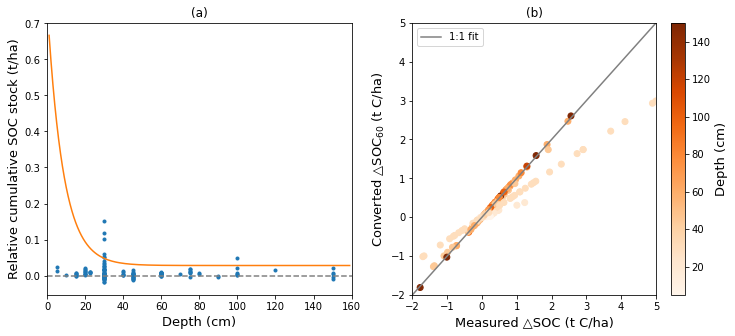

In [54]:
# plot a figure of relative cumulative SOC change
# plot a figure comparing SOC values before and after the depth transformation
NT_deltaSOC = data_cum['delta_SOC_sameinit'][data_cum['Experiment'] == 'Tillage']
NT_SOC = data_cum['Stock_ctr_end'][data_cum['Experiment'] == 'Tillage']
NT_depth = data_cum['Depth_ctr_end'][data_cum['Experiment'] == 'Tillage']
NT_deltaSOC60 = data_cum['delta_SOC_sameinit_NTeffect_60'][data_cum['Experiment'] == 'Tillage']

re_SOC = NT_deltaSOC / NT_SOC

x = np.array(range(1, 160))
y = 0.028 + 0.72*np.exp(-0.12*x)

print(NT_deltaSOC[NT_depth == 5].max(), NT_deltaSOC[NT_depth == 30].max())
print(NT_deltaSOC60[NT_depth == 5].max(), NT_deltaSOC60[NT_depth == 30].max())
# print(re_SOC.dropna().values)

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(NT_depth.values, re_SOC.values, '.')
ax1.plot(x, y)
ax1.plot([0,160], [0,0], '--', c='gray')
ax1.set_xlim([0,160])
ax1.set_xlabel('Depth (cm)', fontsize = 13)
ax1.set_ylabel('Relative cumulative SOC stock (t/ha)', fontsize = 13)
ax1.set_title('(a)')


cMap = 'Oranges'
sc = plt.scatter(NT_deltaSOC, NT_deltaSOC60, c=NT_depth, cmap = cMap)
ax2.set_xlim([-2,5])
ax2.set_ylim([-2,5])
ax2.plot([-2,6], [-2,6], c='gray', label = '1:1 fit')
ax2.set_xlabel('Measured △SOC (t C/ha)', fontsize = 13)
ax2.set_ylabel(r'Converted △SOC$_{60}$ (t C/ha)', fontsize = 13)
cbar = plt.colorbar(sc)
cbar.set_label('Depth (cm)', fontsize = 13)
ax2.set_title('(b)')
plt.legend()
plt.show()

fig1.savefig(plot_dir + 'SOC_convert.png', dpi=300)

['Dry combustion' 'Walkley-Black Method' 'Loss on Ignition'
 'Sercon ratio stable isotopic mass spectrometer' 'modified Mebius method'
 'Wet combustion'] Method_SOC
Dry combustion                                    197
Loss on Ignition                                    6
Sercon ratio stable isotopic mass spectrometer      1
Walkley-Black Method                               14
Wet combustion                                      8
modified Mebius method                              3
Name: Method_SOC, dtype: int64
['Mannual chambers' 'Chamber' 'Vented chamber' 'Static chamber'
 'Automatic chamber'] Method_N2O
Automatic chamber    14
Chamber              22
Mannual chambers      6
Static chamber       32
Vented chamber       43
Name: Method_N2O, dtype: int64
['Orifice ' 'Lysimeter' 'PVC pipe' 'Plastic bottles' 'Pump' 'Moniter well'
 'in-line water control structures' 'litterbag'] Method_Nleach
Lysimeter                           31
Moniter well                         2
Orifice         

D:\workingProgramProfile\Anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\workingProgramProfile\Anaconda\lib\site-packages\ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\workingProgramProfile\Anaconda\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


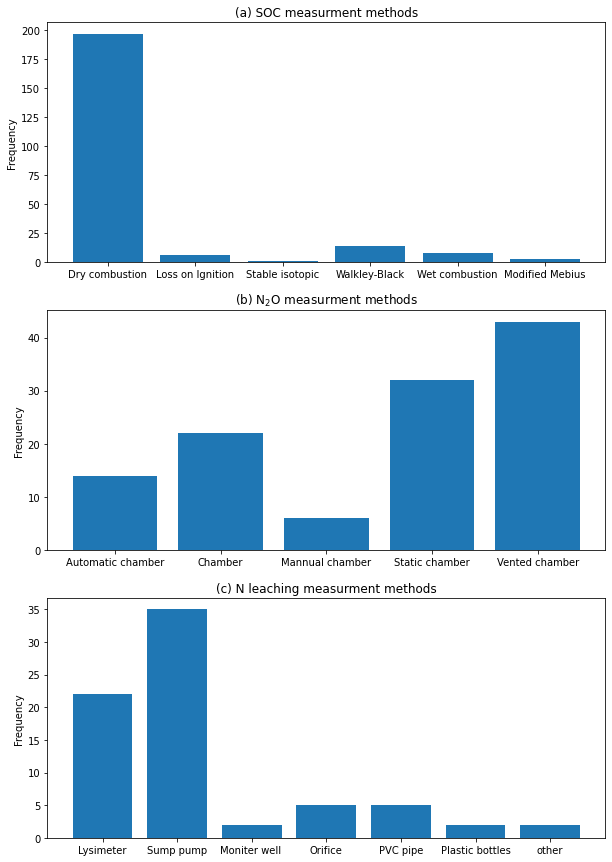

In [30]:
# summarize the measurment methods

N2O_method = data_cum['Method_N2O'].dropna()
SOC_method = data_cum['Method_SOC'].dropna()
lch_method = data_cum['Method_Nleach'].dropna()
data_cum['Method_Nleach'] = data_cum['Method_Nleach'].replace('Sump')

N2O_method_count = N2O_method.groupby(N2O_method).size()
SOC_method_count = SOC_method.groupby(SOC_method).size()
lch_method_count = lch_method.groupby(lch_method).size()
print(SOC_method.unique(), SOC_method_count)
print(N2O_method.unique(), N2O_method_count)
print(lch_method.unique(), lch_method_count)

fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(10,15))
ax1.bar(range(len(SOC_method.unique())), SOC_method_count)
# ax1.set_xticklabels(SOC_method)
# ax1.set_xlabel('SOC measurment method')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['','Dry combustion','Loss on Ignition','Stable isotopic','Walkley-Black', 'Wet combustion','Modified Mebius'])
ax1.set_title('(a) SOC measurment methods')

ax2.bar(range(len(N2O_method.unique())), N2O_method_count)
# ax2.set_xticklabels(N2O_method)
# ax2.set_xlabel('N2O measurment method')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['','Automatic chamber','Chamber','Mannual chamber', 'Static chamber', 'Vented chamber'])
ax2.set_title(r'(b) N$_2$O measurment methods')

ax3.bar(range(7), [22,35,2,5,5,2,2])
# ax2.set_xticklabels(N2O_method)
# ax2.set_xlabel('N2O measurment method')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['','Lysimeter', 'Sump pump', 'Moniter well ','Orifice', 'PVC pipe', 'Plastic bottles', 'other'])
ax3.set_title(r'(c) N leaching measurment methods')

fig1.savefig(plot_dir + 'SOC_N2O_measuremethods.png', dpi=300)